# Section 8 - Analytical Statistical Assessment

Last section: trends in data can arise by chance. Avoid wrong conclusions by using e.g. statistical hypothesis testing via permutation.

This section: more analytical testing approaches, making stronger assumptions on underlying data.

In [1]:
library(data.table)
library(ggplot2)
library(tidyr)
library(magrittr)
library(gridExtra)

options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 100)

file_path <- file.path("/Users", "donatabuozyte", "Downloads", "extdata")


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
# --------------------

## Motivation: Hypothesis Testing in Large Datasets

In big data era: how to test association between multiple up to million data points? Many tests can lead to misleading results, as even if possibility to e.g. falsy reject null hypothesis, it will happen often when many tests are done. Hence lower, scaleable P-values (if $P \leq \frac{r+1}{m+1}$, then $\frac{1}{m+1} \leq P$) are needed for many tests. (`multiple testing problem`)

In [3]:
# --------------------

## Binomial Test: Testing Hypotheses for Single Binary Variable

### 1. Abstraction: Tossing Coin

Experiment: test if coin is biased.

Notation:
- $n$: total number of independent, random tosses
- $X_{i}$ (i.i.d.): value of i-th toss with 1 = head and 0 = tail
- $\mu = E(X_{i}) = p(X_{i} = 1)$

Ingredients:
- $H_{0}$: null hypothesis
- $T$: test statistic
- $p(T | H_{0})$: distribution of test statistic under null hypothesis

---

Choose $H_{0}: \mu = 0.5$ (i.e. coin is fair), hence $H_{1}: \mu \neq 0.5$.
Choose $T = \sum_{i} X_{i}$ (i.e. number of heads).

#### 1.1 Single Coin Toss

Scenario: two possible outcomes (head/tail), equally likely under null hypothesis, $T_{\mathrm{obs}} = 1$ (i.e. toss is head).

Hence: $p(T=0 | H_{0}) = p(T=1 | H_{0}) = 0.5$ and $P = 2 \cdot \min \{p(T \leq T_{\mathrm{obs}} | H_{0}), p(T \geq T_{\mathrm{obs}} | H_{0})\} = 1$ (two sided P-value as direction of bias not important).

Conclusion: no sufficient evidence for rejection null hypothesis in two sided test, but $p(H_{0}) = 1$ isn't correct either.

#### 1.2 Tossing Coin Several Times

Probability of observing $T$ head after $n$ tosses given by binomial distribution (binomial coefficient): $p(T | n, \mu) = \begin{pmatrix} n \\ T \end{pmatrix} \mu^{T} (1-\mu)^{n-T}$, i.e. (number of possible events with same amount of heads) times (probability of given sequence).

Hence: $p(T | n, \mu=0.5) = \begin{pmatrix} n \\ T \end{pmatrix} 0.5^{n}$ = `dbinom(x=T, size=n, prob=0.5)`.

Two sided P-value: $P = 2 \cdot \min \{p(T \leq T_{\mathrm{obs}} | H_{0}), p(T \geq T_{\mathrm{obs}} | H_{0})\} = 2 \cdot \min \{\sum_{T \leq T_{\mathrm{obs}}} \begin{pmatrix} n \\ T \end{pmatrix} 0.5^{n}, \sum_{T \geq T_{\mathrm{obs}}} \begin{pmatrix} n \\ T \end{pmatrix} 0.5^{n}\}$.

---

For example: $P = 2 \cdot \sum_{T \geq 7} \begin{pmatrix} 10 \\ T \end{pmatrix} 0.5^{10} = 2 \cdot (1 - \sum_{T \leq 6} \begin{pmatrix} 10 \\ T \end{pmatrix} 0.5^{10})$

In [4]:
# example under null hypothesis:
set.seed(7)  
n <- 10

# assume that null hypothesis is true
x <- sample(c(0,1), n, replace=TRUE, prob=c(0.5,0.5))     # prob = probability of each outcome
t <- sum(x)                                               # test statistic
x
t

dbinom(x=t, size=n, prob=0.5)                             # (n over T) times 0.5^n

2*(1-pbinom(q=t-1, size=n, prob=0.5))                     # P-value

# conclusion: do not reject null hypothesis

[1] 0 1 1 1 1 0 1 0 1 1

[1] 7

[1] 0.1171875

[1] 0.34375

### 2. Computing Binomial Test with R (`binom.test()`)

`binom.test()` parameters: `t` =  $T_{\mathrm{obs}}$, `n` = $n$ and `p` = $(\mu \;\mathrm{under}\; H_{0})$.

Additional parameter: `alternative` $\in$ {"two.sided", "greater", "less"}, i.e. either one- or two-sided test.

In [5]:
# based on example above
test <- binom.test(t, n, p = 0.5, alternative = c("two.sided"))
test$p.value

test

[1] 0.34375


	Exact binomial test

data:  t and n
number of successes = 7, number of trials = 10, p-value = 0.3438
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.3475471 0.9332605
sample estimates:
probability of success 
                   0.7 


In [6]:
# --------------------

## Fisher’s Exact Test: Testing Association Between Two Binary Variables

Suppose: try to determine whether smokers are more likely to develop severe symptoms conpared to non-smokers.

Data:
$\begin{matrix}
(n=110) & \textbf{Severe} & \textbf{Mild} \\
\textbf{Smoker} & 10 & 20 \\
\textbf{Non-smoker} & 10 & 70 \\
\end{matrix}$

Observation:
- non-smokers: $\frac{1}{8}$ developed severe symptoms, i.e. **odds** are 1:7
- smokers: $\frac{1}{3}$ developed severe symptoms, i.e. **odds** are 1:2

Conclusion: possible relationship between smoking and developing severe symptoms, i.e. **odds** are 3.5 times higher.

Test conclusion, but not with binomial test (as inverstigating relationship between variables).

### 1. Permutation Testing and Hypergeometric Distribution

Null hypothesis: smoking and symptoms are independent.

First: consider underlying, not aggregated data set of individual cases (tidy!)
$\rightarrow \begin{matrix}
\textbf{Patient} & \textbf{Smoker} & \textbf{Symptoms}\\
patient\_1 & n & mild \\
patient\_2 & y & severe \\
patient\_3 & n & severe \\
\ldots & \ldots & \ldots \\
\end{matrix}$

Then: simulate data under null hypothesis by permutation of one column ("Symptoms"). Keeps number of smokers and number of patients with severe symptoms constant.

Lastly: summarize result in *contingency table*
$\rightarrow \begin{matrix}
(n=110) & \textbf{Severe} & \textbf{Mild} & \textbf{Total (constant)} \\
\textbf{Smoker} & a & b & a+b \\
\textbf{Non-smoker} & c & d & c+d \\
\textbf{Total (constant)} & a+c & b+d & a+b+c+d = n \\
\end{matrix}$

Distribution of $a$ under null hypothesis: $p(k=a | H_{0}) = \frac{(a+b)!(c+d)!(a+c)!(b+d)!}{a!b!c!d!n!}$ (hypergeometric), i.e. frequency of $a$ among all possible permutations.

### 2. Fisher’s Exact Test

Derive one-sided P-value based on (hypergeometric or other) distribution: $P = \sum_{i \geq a} p(k=i | H_{0})$ (Fisher’s exact test).

Remember: underlying assumptions, i.e. margins/totals in contingency table are constant.

But: assumptions often violated in practice, but Fisher’s exact test is still applied.

---

Alternatives: Chi-squared test (based on larger number approximations), logistic regression.

### 3. Fisher’s Exact Test in R (`fisher.test()`)

Input: data table, optionally an `alternative`.

Output: P-value, extimate of odds ratio, confidence interval

In [7]:
tbl = data.table(
  severe = c(10, 10),
  mild = c(20, 70)
)
test <- fisher.test(tbl,  alternative = "greater")

test$p.value
test

# conclusion: reject null hypothesis

severe 
0.01480945


	Fisher's Exact Test for Count Data

data:  tbl
p-value = 0.01481
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 1.316358      Inf
sample estimates:
odds ratio 
  3.453224 


In [8]:
# --------------------

## Testing Association Between One Quantitative and One Binary Variable

Question: genotype at marker 5211 significantly associated with growth rates in Maltose media?

So far: yeast strains which with wild isolate genotype generally grow faster than those with lab strain genotype.

---

Evaluation of association between binary variable (genotype at marker) and quantitative variable (growth rate in Maltose media) hence new test needed!

Define groups based on binary variable: $X$ = quantitative data of first group (lab strain genotype), $Y$ = quantitative data of second group (wild isolate genotype).

Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”

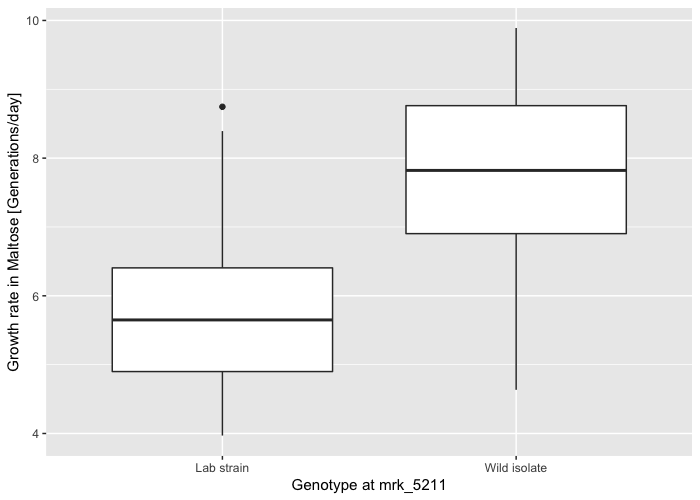

In [9]:
genotype <- fread(file.path(file_path, "eqtl", "genotype.txt"))
genotype <- genotype %>% melt(id.vars = 'strain', variable.name = 'marker', value.name = 'genotype')
marker <- fread(file.path(file_path, "eqtl", "marker.txt"))
growth <- fread(file.path(file_path, "eqtl", "growth.txt"))
growth <- growth %>% melt(id.vars = "strain", variable.name = 'media', value.name = 'growth_rate')

mk <- marker[chrom == "chr07" & start == 1069229, id]

dt <- merge(
  growth[media == 'YPMalt'],
  genotype[marker == mk, .(strain, genotype)],
  by = 'strain'
)

p <- dt%>% 
  ggplot(., aes(genotype, growth_rate)) +
  geom_boxplot() +
  xlab(paste0("Genotype at ", mk)) + 
  ylab("Growth rate in Maltose [Generations/day]")

p

### 1. The *t*-test

Student's *t* test statistic: $t = c \frac{\bar{x} - \bar{y}}{s}$ with
1. means $\bar{z} = \frac{1}{n_{Z}} \sum_{i} z_{i}$.
2. pooled standard deviation $s = \sqrt{\frac{\sum_{i} (x_{i} - \bar{x})^{2} + \sum_{j} (y_{j} - \bar{y})^{2}}{n_{X} + n_{Y} -2}}$.
3. constant $c = \sqrt{\frac{n_{X} n_{Y}}{n_{X} + n_{Y}}}$.

Intuitively: *t* statistic compares (up to constant $c$) "signal" of group difference (e.g. estimated difference of group means) to "noise" (i.e. uncertainty about estimation), hence test statistic is a "signal-to-noise" ratio.

Interpretation: large statistic (caused by e.g. more data, large between-group differences) = clear signal, small statistic = signal not large compared to noise.

#### 1.1 Student’s *t*-distribution

Additional assumptions:
1. All observations are independent of each other.
2. X and Y are Gaussian distributions and have same (unkown) variance.

Consequence: null hypothesis simplifies, i.e. $H_{0}: E(X) = E(Y)$, as only possible difference by definition is the mean. Hence test statistic *t* under null hypothesis follows Student's *t*-distribution with $\nu = n_{X} + n_{Y} - 2$ degrees of freedom (see https://en.wikipedia.org/wiki/Student%27s_t-distribution).

Observations:
1. distribution of test statistic under null hypothesis not dependend on variance.
2. Student's *t*-distribution has heavier tails than Gaussian as numerator of *t*-statistic normally distributed, but estimate of standard deviation in denominator is noisy.

---

Note: smaller sample size -> noisier estimate. Hence: smaller degrees of freedom -> heavier tails, infinite degrees of freedom -> Student's *t*-distribution = normal distribution. 

#### 1.2 Student’s *t*-distribution in R (`t.test(..., var.equal=TRUE)`)

As equal variance assumed: `var.equal=TRUE`.

Extraction of values for each group: `var1 ~ var2`, e.g. `growth_rate ~ genotype`.

Output: *t*-statistic, degrees of freedom, confidence intervals for difference of means, P-value.

In [10]:
t.test(growth_rate ~ genotype, data=dt, var.equal=TRUE)


	Two Sample t-test

data:  growth_rate by genotype
t = -10.77, df = 152, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.406400 -1.660387
sample estimates:
  mean in group Lab strain mean in group Wild isolate 
                  5.763086                   7.796480 


#### 1.3 Unequal Variance (Welch’s Test) in R (`t.test()`)

Case: don't assume equal variances. Slightly changes degrees of freedom.

In [11]:
t.test(growth_rate ~ genotype, data=dt)


	Welch Two Sample t-test

data:  growth_rate by genotype
t = -10.805, df = 152, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.405189 -1.661599
sample estimates:
  mean in group Lab strain mean in group Wild isolate 
                  5.763086                   7.796480 


### 2. Wilcoxon Rank-Sum Test: Alternative to t-test for Non-Gaussian Data

#### 2.1 Assumptions

1. All observations are independent of each other.
2. Responses are ordinal (i.e. can be ranked).

Specifically: assume that under null hypothesis, probability of observation from population X exceeding observation from population Y equals to probablity of observation from Y exceeding observation from X, i.e. $H_{0}: p(X > Y) = p(Y > X)$.

For two-sided test: alternative hypothesis is $H_{1}: p(X > Y) \neq p(Y > X)$.

#### 2.2 Mann-Whitney U Statistic and Wilcoxon Rank-Sum Test

Consider some ranking of all observed values.

Idea of Wilcoxon rank-sum test: under null hypothesis, observed values should be well interleaved in ranking, hence test statistic is based on sum of ranks of realizations of one variable.

---

Mann-Whitney U statistic: $U = \min \{ U_{X}, U_{Y} \}$ with $U_{Z} = R_{Z} - \frac{n_{Z}(n_{Z}+1)}{2}$ and the sum of the ranks of the elements of set $Z$ $R_{Z}$.

P-value: based on distribution of Mann-Whitney U statistic under null hypothesis.

Note: $\frac{n_{Z}(n_{Z}+1)}{2}$ is Gauss sum, i.e. if all first values are from $Z$, then $U_{Z} = 0$.

#### 2.3 Wilcoxon Rank-Sum Test in R (`wilcox.test()`)

In [12]:
wilcox.test(growth_rate ~ genotype, data=dt)


	Wilcoxon rank sum test with continuity correction

data:  growth_rate by genotype
W = 690, p-value = 2.264e-16
alternative hypothesis: true location shift is not equal to 0


### 3. Why Bother With Wilcoxon Rank-Sum Test?

Advantage: no Gaussian distribution required.

---

Example: groups sampled from normal distribution with different means. Add non-normal outlier to second group to ensure that overall mean looks the same.

Consequence of Gaussian-assumption: null hypothesis of *t*-test is difference of means being 0. As means are the same, *t*-test cannot reject null hypothesis.

Actual observation: groups quiet different, means only similar due to outlier. Hence null hypothesis is rejected in Wilcoxon rank-sum test (not based on means!).

---

**Summary**: Wilcoxon rank-sum test more robust (especially if distirbution unknown), but *t*-test more powerful (i.e. can detect violations of null hypothesis better) for Gaussian data.


	Welch Two Sample t-test

data:  x1 and x2
t = -0.00052129, df = 99.072, p-value = 0.9996
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -9.829688  9.824525
sample estimates:
mean of x mean of y 
 9.863451  9.866033 



	Wilcoxon rank sum test with continuity correction

data:  x1 and x2
W = 9900, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


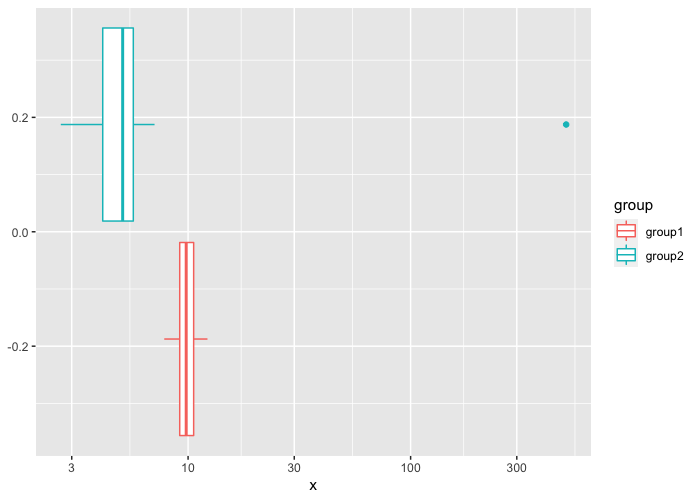

In [13]:
set.seed(10)
x1 <- rnorm(100, 10)
x2 <- c(rnorm(99, 5), 500)
grp_tbl <- data.table(
  group = rep(c("group1", "group2"), each=100),
  x = c(x1,x2)
)

t.test(x1, x2)
wilcox.test(x1, x2)

ggplot(data = grp_tbl, aes(x=x, color=group)) +
    geom_boxplot() +
    scale_x_log10()

In [14]:
# --------------------

## Association between two quantitative variables

Assumption: data in form of tuples, i.e. $(X,Y): (x_{1}, y_{2}), \ldots, (x_{n}, y_{n})$.

Question: does knowing one value in tuple give us information about other one?

### 1. Pearson Correlation Test

Additional assumptions:
1. Data from bivariate Gaussian distribution.
2. Observations are i.i.d.

2. Independence of variables is equivalent to their population in Pearson correlation coefficient $\rho_{X, Y} = 0$.

# TODO: what does that mean hae

#### 1.1 Pearson’s Correlation Coefficient

Sample estimate of population Pearson correlation coefficient: $r = \frac{\sum_{i} (x_{i} - \bar{x})(y_{i} - \bar{y})}{\sqrt{\sum_{i} (x_{i} - \bar{x})^{2}} \sqrt{\sum_{i} (y_{i} - \bar{y})^{2}}} \in [-1, 1]$.

Remarks:
- invariant to affine trafos.
- numerator: compare deviation of $x_{i}$ and $y_{i}$ to respective means.
- numerator: term in sum positive, if $x_{i}$ and $y_{i}$ vary in same direction compared to their mean.
- numerator (formally): proportional to sample covariance.
- denominator: terms proportional to individual sample standard deviations of the variables.

Summary: $r$ compares how much the variables vary together to product of how much they cary individually.

Interpretation:
- $r = 1$: variables perfectly linear related with positive slope.
- $r = -1$: variables perfectly linear related with negative slope.

#### 1.2 The Test (`cor.test(... , method="pearson"`)

Null hypothesis: variables are statistically independent, i.e. $H_{0}: \rho_{(X, Y)} = 0$.

Test statistic: $t = r \cdot \sqrt{\frac{n-2}{1-r^{2}}}$.

Remark: test statistic under null hypothesis follows Student's *t*-distribution with degrees of freedom $n-2$.

In [15]:
cor.test(anscombe$x1, anscombe$y1, method="pearson")


	Pearson's product-moment correlation

data:  anscombe$x1 and anscombe$y1
t = 4.2415, df = 9, p-value = 0.00217
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4243912 0.9506933
sample estimates:
      cor 
0.8164205 


### 2. Spearman Rank Correlation Test

#### 2.1 Motivation

Pearson’s correlation: capture *linear* relationship between variables.

Problem: if one variable is in log-scale or quadratic scale, then linear relationship is lost.

Example 1: variables relate by monotonic realtionship (tangent function), but Pearson correlation is modest.

Example 2: Pearson correlation large in presence to outliers which destroy relationship.

[1] 0.5643079

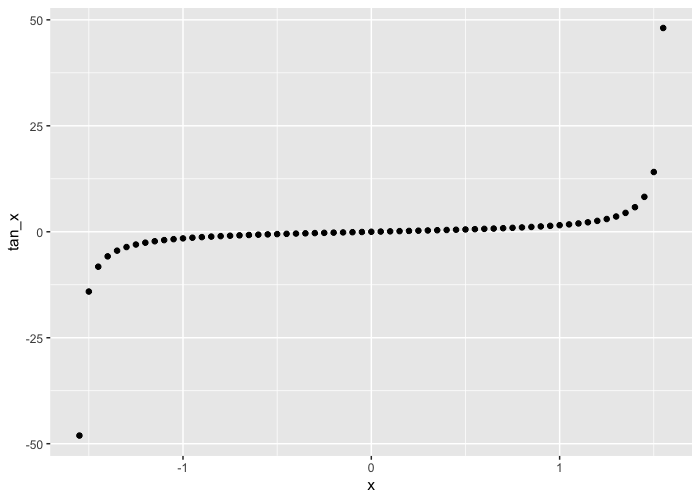

In [16]:
x_vec <- seq(-1.55,1.55,0.05)
tan_x <- tan(x_vec)
dt_tan <- data.table(x = x_vec, tan_x = tan_x)

cor(x_vec, tan_x, method="pearson")

ggplot(data=dt_tan, aes(x=x, y=tan_x)) +
    geom_point()

In [17]:
cor.test(anscombe$x4, anscombe$y4, method="pearson")

# conclusion: significant statistical association, but only driven by one outlier.


	Pearson's product-moment correlation

data:  anscombe$x4 and anscombe$y4
t = 4.243, df = 9, p-value = 0.002165
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4246394 0.9507224
sample estimates:
      cor 
0.8165214 


#### 2.2 Spearman’s Correlation Coefficient (`cor(... , method="spearman")`)

Spearman’s correlation addresses mentioned issues by computing correlation on rank-transformed values (instead of on original scale).

---

Rank such that: $z_{i} < z_{j} < \ldots$.

Then compute position of each data point in ranking to get transformed dataset: $\mathrm{rank}_{X}X, \mathrm{rank}_{Y}Y = (\mathrm{rank}_{X}(x_{1}), \mathrm{rank}_{Y}(y_{1})), \ldots, (\mathrm{rank}_{X}(x_{n}), \mathrm{rank}_{Y}(y_{n}))$.

In [18]:
cor(rank(anscombe$x4), rank(anscombe$y4), method="pearson")

cor(anscombe$x4, anscombe$y4, method="spearman")

[1] 0.5

[1] 0.5

#### 2.3 The Test

Define relationship between two variables based on Spearman’s correlation.

No distributional assumptions.

Null hypothesis: population rank-correlation is 0.

---

Remark: Spearman test less powerful than Pearson when data Gaussian, but more robust to outliers, captures monotonic, yet non-linear, relationships. Hence often used.

In [19]:
# Remark: implementation based on tabulated exact permutations for small sample sizes
#         and approximations for larger sample sizes.

cor.test(anscombe$x4, anscombe$y4, method="spearman")

# conclusion: do not reject null hypothesis.

Warning message in cor.test.default(anscombe$x4, anscombe$y4, method = "spearman"):
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  anscombe$x4 and anscombe$y4
S = 110, p-value = 0.1173
alternative hypothesis: true rho is not equal to 0
sample estimates:
rho 
0.5 


In [20]:
# --------------------

## Testing Associations of Two Variables: Overview

See figure 8.3 in script (https://gagneurlab.github.io/dataviz/analytical-stat.html#why-bother-with-the-wilcoxon-rank-sum-test).

In [21]:
# --------------------

## Assessing Distributional Assumptions with Q-Q Plots

Plot to check whether distributional assumptions are reasonable.

Examples:
- check uniformly distribution of P-values
- detect outliers
- check if data approx. normally distributed before running t-test oder testing coefficients of linear regression

### 1. Limitations of Histograms

Visualize distributions: histograms.

Problem: difficult to choose right bin size to check distributional assumptions.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


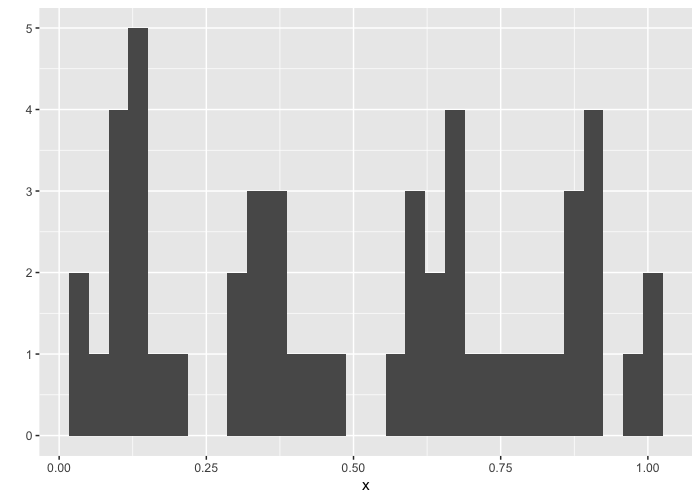

In [22]:
# Example: uniformly distributed data points, but hard to see in histogram.

x <- runif(50)
# qplot is a quick plotting function
qplot(x, geom="histogram")

### 2. Q-Q (Quantile-Quantile) Plots: Comparing Empirical to Theoretical Quantiles (via `ppoints()`)

Idea: look at quantiles. If data follows e.g. uniform distribution on interval 0 to 1, then 10% of the data shouls be in the interval 0 to 0.1, 20% of the data shouls be in the interval 0 to 0.2, ...

---

Remark: quiet robust against outliers, as they are clearly visible.

0%        10%        20%        30%        40%        50%        60% 
0.02503686 0.09677631 0.14369892 0.29974460 0.36662386 0.50953583 0.63289259 
       70%        80%        90%       100% 
0.68685499 0.85694255 0.90948354 0.99981636

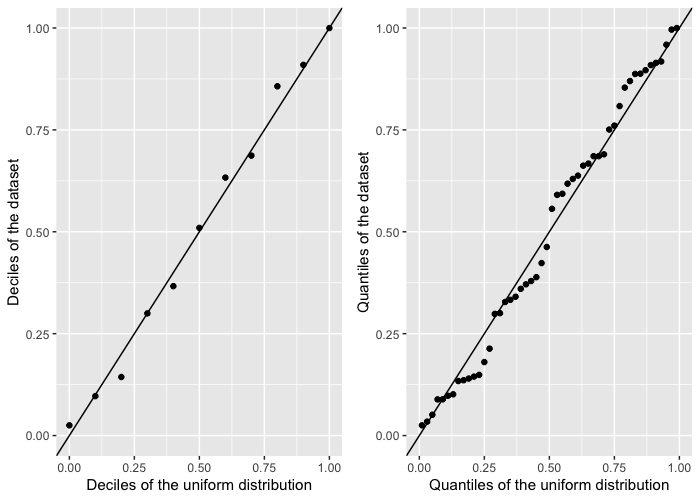

In [23]:
# example:

# implicitly chose to always make jumps of 10%
dec <- quantile(x, seq(0,1,0.1))
dec

# comparison: expected and theoretical deciles
p1 <- ggplot(data.table(x=seq(0,1,0.1), y=dec), aes(x,y)) +
        geom_point() +
        xlim(c(0,1)) +
        ylim(c(0,1))+
        xlab("Deciles of the uniform distribution") +
        ylab("Deciles of the dataset") +
        geom_abline(intercept=0,slope=1) # diagonal y=x
# result:match quiet well

# estimate quantile for every data point for finite sample -> ppoints
# one way: use as expected quantile (r-0.5)/N with rank r of the data point
p2 <- ggplot(data.table(x=ppoints(length(x)), y=sort(x)), aes(x,y)) +
        geom_point() +
        xlim(c(0,1)) +
        ylim(c(0,1)) +
        xlab("Quantiles of the uniform distribution") +
        ylab("Quantiles of the dataset") +
        geom_abline(intercept=0,slope=1) # diagonal y=x
# interpretation: points close to diagonal = distribution matches data

grid.arrange(p1, p2, ncol=2, nrow=1)

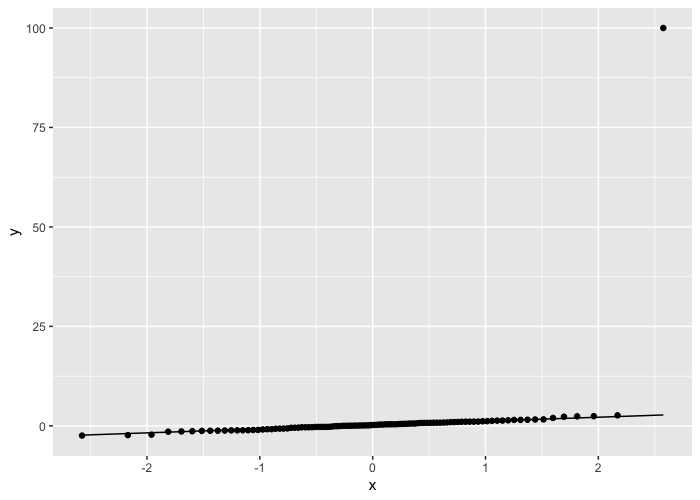

In [24]:
# test: what if outlier is added?
group_qq <- c(rnorm(99, 0), 100)
qq_tbl <- data.table(sample = group_qq)
ggplot(data = qq_tbl, aes(sample = sample)) +
    geom_qq() +
    stat_qq_line()
# outlier shows up clearly as a strong deviation from what we expect from normal distribution

### 3. Typical Q-Q Plots

See https://gagneurlab.github.io/dataviz/assets/img/lec11-QQ-plots.png for the examples.

Assumption: normal distribution (Gaussion with mean 0, variance 1) as reference theoretical distribution.

Middle three plots show consequence of one aspect of distributional assumption being incorrect:
- second plot: consequence of data with higher mean than expected, but otherwise follows distribution.
- middle plot: consequence of data having fatter tails (i.e. more outliers) than expected. (occurs frequently)
- fourth plot: consequence of narrower distribution than expected.

Last plot: combination of the above phenomena, shows lack of low values and excess of high values. (Data from non-negative asymmetric distribution)

In [25]:
# --------------------

## Analytical Confidence Intervals

Reminder: confidence interval of confidence level $1-\alpha$ for parameter $\theta$ is an interval, which would data generation process be repeated, would contain parameter with probability $1-\alpha$.

### 1. Binomial Case

Set-up as before:
- $N$: total number of independent, random tosses
- $X_{i}$ (i.i.d.): value of i-th toss with 1 = head and 0 = tail
- $\mu = E(X_{i}) = p(X_{i} = 1)$
- $\bar{X} = \frac{1}{N} \sum_{i} X_{i}$: sample mean, random variable
- $\hat{SE}(\bar{X}) = \sqrt{\frac{\bar{X}(1-\bar{X})}{N}}$: estimated standard deviation, random variable

Goal: probability of interval $[\bar{X} - \hat{SE}(\bar{X}), \bar{X} + \hat{SE}(\bar{X})]$ containing true prportion $\mu$, i.e $p(\bar{X} - \hat{SE}(\bar{X}) \leq \mu \leq \bar{X} + \hat{SE}(\bar{X})) = p(-1 \leq \frac{\bar{X} - \mu}{\hat{SE}(\bar{X})} \leq 1)$.

#### 1.1 Normal Approximation Interval Using Central Limit Theorem

By Central Limit Theorem: sample mean distributes for large *N* as Normal distribution with mean $E(X)$, variance $Var(X)/N$, i.e. $p(\bar{X}) = N(\mu, \frac{Var(X)}{N})$.

As $Var(X_{i}) = \mu(1-\mu)$: $p(-1 \leq \frac{\bar{X} - \mu}{\hat{SE}(\bar{X})} \leq 1) = p(-1 \leq Z \leq 1)$ where Z is normally distributed with mean 0, variance 1.

In [26]:
# computation in R:
pnorm(1) - pnorm(-1)

[1] 0.6826895

#### 1.2 Defining the Interval for Predefined Confidence Level

If probability should be higher, e.g. 99%: find *z* s.t. $p(-z \leq Z \leq z)=0.99$.

In [27]:
z <- qnorm(0.995)        # quantile function of normal distribution
z
# Valid as by definition pnorm(qnorm(0.995)) is 0.995 and by symmetry pnorm(1-qnorm(0.995)) is 1-0.995.
# Hence 0.995 - (1-0.995) = 0.995 - 0.05 = 0.99:
pnorm(z) - pnorm(-z)

[1] 2.575829

[1] 0.99

#### 1.3 Boundaries of Equi-Tailed 95% Confidence Interval

Obtain equi-tailed confidence interval of level $1-\alpha$ by setting `z = qnorm(1 - alpha/2)` as $(1-\frac{\alpha}{2}) - \frac{\alpha}{2} = 1 - \alpha$.

Note: can be used for any confidence level $1-\alpha$.

In [28]:
qnorm(0.975)

[1] 1.959964

### 2. Confidence Intervals in R

Most statistical tests provide confidence intervals for relevant statistic.

Default: 95% confidence interval. Set confidence interval with `conf.level`.

Note: sometimes not provided, bun can be often computed via `conf.int=TRUE`.

In [29]:
# examples:
mu <- 0.45
N <- 1000
x <- sample(c(0, 1), size = N, replace = TRUE, prob = c(1-mu, mu))
binom.test(sum(x), length(x))

binom.test(sum(x), length(x))$conf.int

binom.test(sum(x), length(x), conf.level=0.99)$conf.int

wilcox.test(growth_rate ~ genotype, data=dt, conf.int=TRUE)


	Exact binomial test

data:  sum(x) and length(x)
number of successes = 421, number of trials = 1000, p-value = 6.537e-07
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.3901707 0.4522958
sample estimates:
probability of success 
                 0.421 


[1] 0.3901707 0.4522958
attr(,"conf.level")
[1] 0.95

[1] 0.3807435 0.4620192
attr(,"conf.level")
[1] 0.99


	Wilcoxon rank sum test with continuity correction

data:  growth_rate by genotype
W = 690, p-value = 2.264e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -2.537024 -1.753245
sample estimates:
difference in location 
             -2.134131 


### 3. Advanced: Note on Overlapping Confidence Intervals

Assume: $X \sim N(\mu_{X}, \sigma^{2})$, $Y \sim N(\mu_{Y}, \sigma^{2})$.

If $n_{X} = n_{Y} = n$: $\bar{x} \sim N(\mu_{X}, \frac{\sigma^{2}}{n})$, $\bar{y} \sim N(\mu_{Y}, \frac{\sigma^{2}}{n})$.

As before: $p(\bar{x} - z \frac{\sigma}{\sqrt{n}} \leq \mu_{X} \leq \bar{x} + z \frac{\sigma}{\sqrt{n}}) = p(-z \leq \frac{\bar{x} - \mu_{X}}{\frac{\sigma}{\sqrt{n}}} \leq z) = p(-z \leq Z \leq z) = 0.95$ with $Z \sim N(0, 1)$. Hence $z \approx 1.96 \approx 2$.

Confidence intervals are therefore: $\bar{x} \pm 2 \frac{\sigma}{\sqrt{n}}$, $\bar{y} \pm 2 \frac{\sigma}{\sqrt{n}}$.

---

Goal: test null hypothesis that true mean difference is 0. Reject iff two confidence intervals do not overlap, i.e. when $\bar{y} + 2 \frac{\sigma}{\sqrt{n}} < \bar{x} - 2 \frac{\sigma}{\sqrt{n}} \iff 4 \frac{\sigma}{\sqrt{n}} < \bar{x} - \bar{y}$.

Note: goal is *not* the same as constructing 95% confidence interval for difference in means and rejecting iff interval does not include 0. Difference is due to addition of standard errors.

Construction of intervals for $\bar{x} - \bar{y}$: as $\bar{x} - \bar{y} \sim N(\mu_{X} - \mu_{Y}, 2 \frac{\sigma^{2}}{n})$, the interval is $(\bar{x} - \bar{y}) \pm 2 \sqrt{2} \frac{\sigma}{\sqrt{n}}$.

Conclusion: reject null hypothesis when $(\bar{x} - \bar{y}) > 2 \sqrt{2} \frac{\sigma}{\sqrt{n}}$

Note: as $2 \sqrt{2} < 4$, this will reject more often than "overlap" test (which is "too conservative").

In [30]:
# --------------------

## Discussion and Conlusion

Permutation-based testing is very general, but is computationally intensive and not always appropriate (e.g. when dealing with Big Data).

Assumptions on the distribution of data influence the null hypothesis, which is based on the parameters, but often non-parametric tests exist and make little assumptions (e.g. Fisher, Wilcoxon rank-sum test, Spearman rank-correlation test). Prefer non-parametric if no good reason for restrictions exist.

Check distributional assumptions using Q-Q plots.

Always report:
- significance assessment (P-value or confidence interval)
- plot showing the effect assessed
- (if relevant) Q-Q plot showing that distributional assumptions of test are met

##### End of Section 8!